# Prediction with HMP feature


In [202]:
# Installs the TensorFlow Library
!pip install -U -q tensorflow

In [203]:
# Code to create a connection between Google Colab and folder with data at Google Drive
from google.colab import drive
import os
drive.mount('/content/drive/')
#os.chdir('/content/drive/My Drive/CA684_Assignment/')
os.chdir('/content/drive/My Drive/CA684/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [204]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing
import tensorflow
import os


In [206]:
# for reproducibility of pseudo-random numbers
from numpy.random import seed
seed(1)

# Import of Progressbar library to show the status of any long process in data processing methods
from progressbar import ProgressBar
pbar = ProgressBar()

In [207]:
!ls

Arun_Baluni_20214584.docx  hmp_features_dev_data.csv  TestWork.ipynb
Dev-set			   HMP_predict.ipynb
hmp_data_test.csv	   Test-set


In [208]:
# Function to read each line of HMP file for HMP (Histogram of Motion Patterns) features"""              
def read_HMP_data(fname):
    count = 0
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
            count = count + 1
    # There are 6075 bins, fill the numpy array with zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [209]:
# load the ground truth values from Dev-set
ground_truth_path = './Dev-set/Ground-truth/'
ground_truth_labels = pd.read_csv(ground_truth_path+'ground-truth.csv')

hmp_feature_path = './Dev-set/'
# Load video related features
videos = ground_truth_labels.video.values

hmp_Features = pd.DataFrame({'video': videos,
                   'HMP': [read_HMP_data(hmp_feature_path + 'HMP'+'/'+ os.path.splitext(videos[video])[0]+'.txt') for video in pbar(range(len(videos)))]
                       })


100% (6000 of 6000) |####################| Elapsed Time: 0:00:53 Time:  0:00:53


In [210]:
#Saving HMP features in CSV to save data in future data processing
Features.to_csv('hmp_features_dev_data.csv')
hmp_Features.shape

(6000, 2)

In [230]:
# Join the sequence of arrays in along a axis
X = np.stack(Features['HMP'].values)

# Read the Ground Truth label values stored in Dev dataset
Y = ground_truth_labels[['short-term_memorability','long-term_memorability']].values

# Break the input with 80% of data in (X_train, Y_train) for training of data and rest 20% data of (X_val, Y_val) to validate the model
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [213]:
# Load testing data for HMP from the Test-set folder
test_path = './Test-set/'
hmp_test_videos = os.listdir(test_path+'HMP_test')

pbar = ProgressBar()

test_hmp_features = pd.DataFrame({'video': hmp_test_videos,
                   'HMP': [read_HMP_data(test_path+'HMP_test'+'/'+ hmp_test_videos[test_video]) for test_video in pbar(range(len(hmp_test_videos)))],
                       })
# Join the sequence of arrays in along a axis
X_test = np.stack(test_hmp_features['HMP'].values)


100% (2000 of 2000) |####################| Elapsed Time: 0:00:15 Time:  0:00:15


In [214]:
print(len(X_test))

2000


# Building the Model

In [215]:
# Sequential Model
model = Sequential()
model.add(layers.Dense(500,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(500,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(500,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()


model.compile(optimizer='rmsprop',loss=['mae'],metrics=['acc'])

history = model.fit(x=X_train, y=Y_train, batch_size=50, epochs=50, shuffle=True, verbose=False, validation_data=(X_val, Y_val))   # validation_split=0.2 removed 


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 500)               3038000   
_________________________________________________________________
dropout_24 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_25 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_26 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                

# Visualisaton of results
- Visualising the loss and training results
- Visualising the short-term and long term scatter plot

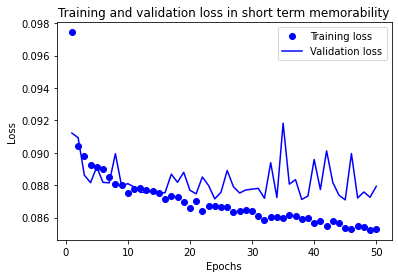

In [216]:
# Visualising the training loss vs validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()

plt.plot(epochs,training_loss,'bo',label='Training loss')
plt.plot(epochs,validation_loss,'b',label='Validation loss')
plt.title('Training and validation loss in short term memorability')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

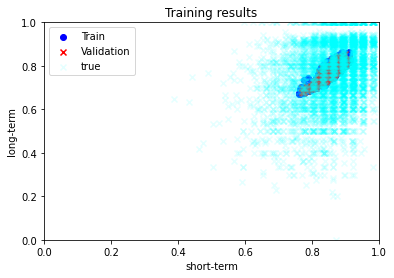

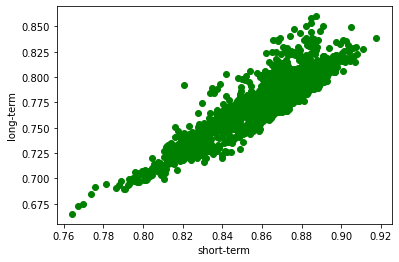

In [218]:
# Training and Validation prediction graph
Y_predicted_train = history.model.predict(X_train)
Y_predicted_validation = history.model.predict(X_val)

plt.figure()
plt.scatter(Y_predicted_train[:,0],Y_predicted_train[:,1],marker='o',c='b',label='Train')
plt.scatter(Y_predicted_validation[:,0],Y_predicted_validation[:,1],marker='x',c='red',label='Validation')
plt.scatter(Y[:,0],Y[:,1],marker='x',c='cyan',label='true',alpha=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.title('Training results')
plt.show()
    
# plot testing results graph
Y_pred = history.model.predict(X_test[:,:],batch_size=32)
plt.figure()
plt.scatter(Y_pred[:,0],Y_pred[:,1],marker='o',c='g', label='test')
plt.xlabel('short-term')
plt.ylabel('long-term')
plt.show()


In [253]:
def Get_score(Y_predicted,Y_actual):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_predicted = np.squeeze(Y_predicted)
    Y_actual = np.squeeze(Y_actual)

    if Y_predicted.shape != Y_actual.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_predicted.shape) == 1:
            Res = pd.DataFrame({'Y_actual':Y_actual,'Y_predicted':Y_predicted})
            score_mat = Res[['Y_actual','Y_predicted']].corr(method='spearman',min_periods=1)
            print('Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
            
        else:
            for k in range(Y_predicted.shape[1]):
                if(k == 0):
                    print('Short term memorability')
                    Get_score(Y_predicted[:,k],Y_actual[:,k])
                else:
                    print('\nLong term memorability')
                    Get_score(Y_predicted[:,k],Y_actual[:,k])

In [254]:
# Memorability Score

Get_score(Y_predicted_validation,Y_val)


Short term memorability
Spearman's correlation coefficient is: 0.325

Long term memorability
Spearman's correlation coefficient is: 0.126


In [255]:
score = model.evaluate(X_val, Y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.08792687952518463
Validation accuracy: 0.7099999785423279
